## Initialization cell: import libraries and define important functions

In [33]:
import requests
import pandas as pd
import pickle
from tempfile import TemporaryFile
from astropy.io.votable import parse as votparse
import numpy as np
import matplotlib.pyplot as plt
from astropy.io.fits import Header
from astropy.wcs import wcs
from io import BytesIO
from PIL import Image, ImageDraw, ImageFont
import ipywidgets as widgets
from bs4 import BeautifulSoup
from bs4 import element

def hips2fits_query(ra, dec, width=500, height=500, fov=0.0667, hips=None):
    '''
    Get an image from the hips2fits service
    '''
    base_url = 'http://alasky.u-strasbg.fr/hips-image-services/hips2fits'
    if hips is None:
        hips = 'CDS/P/DSS2/color'
    params = {
        #'hips':'CDS/P/DSS2/color',
        #'hips':'CDS/P/PanSTARRS/DR1/color-z-zg-g',
        'hips':hips,
        'width':width,
        'height':height,
        'fov':fov, # degrees
        'projection':'TAN',
        'coordsys':'icrs',
        'ra':ra,
        'dec':dec,
        'format':'jpg',
    }
    
    print("Querying hips2fits...")
    response = requests.get(base_url, params=params)
    print("Returned {:s}".format(str(response)))
    return response

def ned_query(ra, dec, dist=3):
    '''
    Query NED with a location
    '''
    if dist > 60:
        dist = 60
    base_url = "http://ned.ipac.caltech.edu/cgi-bin/objsearch"
    params = {
        'search_type':'Near Position Search',
        'in_csys':'Equatorial',
        'in_equinox':"J2000.0",
        'lon':str(ra) + 'd',
        'lat':str(dec) + 'd',
        'radius':dist, # arcmin
        'out_csys':'Equatorial',
        'out_equinox':'J2000.0',
        'of':'ascii_bar',
    }
    return requests.get(base_url, params=params)

def heasarc_query(table, ra, dec, **kwargs):
    '''
    Query a catalog on HEASARC with a location
    '''
    if 'radius' not in kwargs:
        kwargs['radius'] = 30
    if 'resolver' not in kwargs:
        kwargs['resolver'] = 'SIMBAD'
    if 'equinox' not in kwargs:
        kwargs['equinox'] = '2000'
    if 'gifsize' not in kwargs:
        kwargs['gifsize'] = '0'
    if 'fields' not in kwargs:
        kwargs['fields'] = 'STANDARD'
    if 'max_results' not in kwargs:
        kwargs['max_results'] = '0'
    
    base_url='https://heasarc.gsfc.nasa.gov/db-perl/W3Browse/w3query.pl'
    params = {
            "tablehead":"name%3dBATCHRETRIEVALCATALOG%5f2%2e0 {:s}".format(table),
            "Action":"Query",
            "Coordinates":"EQUATORIAL",
            "Equinox":kwargs['equinox'],
            "Radius":kwargs['radius'],
            "NR":kwargs['resolver'],
            "GIFsize":kwargs['gifsize'],
            "fields":kwargs['fields'],
            "Entry":'{:f},{:f}'.format(ra, dec),
            "ResultMax":kwargs['max_results'],
            'Time':'',
            "displaymode":'VODisplay'
            }

    print("Querying HEASARC...")
    response = requests.get(base_url, params=params)
    print("Returned {:s}".format(str(response)))
    
    if response.status_code != 200:
        return None
    
    tf = TemporaryFile()
    tf.write(response.content)
    tf.flush()
    tf.seek(0)
    vot = votparse(tf)
    df = vot.get_first_table().to_table().to_pandas()
        
    return df

###### # could use POST for many objects in one query (return objects uncategorized) or one GET per 2RXS object
def simbad_query(ra, dec, dist=60, response_format='votable'):
    '''
    Query SIMBAD with a location (deprecated)
    '''
    # SIMBAD disallows search radii gt. 180 arcsec
    if dist > 180:
        dist = 180
        
    tf = TemporaryFile(mode='w+')
    tf.write("ra,dec\n{:f},{:f}\n".format(ra, dec))
    tf.mode = 'r'
    tf.flush()
    tf.seek(0)

    payload = {'REQUEST':'xmatch',
                'cat1':'simbad',
                'colRA2':'ra',
                'colDEC2':'dec',
                'distMaxArcsec':dist,
                'RESPONSEFORMAT':response_format,
                }
    base_url = "http://cdsxmatch.u-strasbg.fr/xmatch/api/v1/sync"
    return requests.post(base_url, data=payload, files={'cat2':tf})

def simbad(ra, dec, *args, **kwargs):
    '''
    Query SIMBAD with a location. Return a DataFrame (deprecated)
    '''
    response = simbad_query(ra, dec, *args, **kwargs)
    tf = TemporaryFile()
    tf.write(response.content)
    tf.flush()
    tf.seek(0)
    return votparse(tf).get_first_table().to_table().to_pandas()

def simbad_dataframe_query(df, dist=60, response_format='votable'):
    '''
    Query SIMBAD with a number of locations stored in a DataFrame. Returns a DataFrame
    '''
    # SIMBAD disallows search radii gt. 180 arcsec
    if dist > 180:
        dist = 180
    
    # catalog of ra, dec used for querying X-match must be provided in the
    # form of a file handle
    tf = TemporaryFile(mode='w+')
    tf.write('ra,dec\n');
    for idx, item in df.iterrows():
        tf.write('{:f},{:f}\n'.format(item['ra'], item['dec']))
        
    tf.mode = 'r'
    tf.flush()
    tf.seek(0)

    payload = {'REQUEST':'xmatch',
                'cat1':'simbad',
                'colRA2':'ra',
                'colDEC2':'dec',
                'distMaxArcsec':dist,
                'RESPONSEFORMAT':response_format,
                }
    base_url = "http://cdsxmatch.u-strasbg.fr/xmatch/api/v1/sync"
    
    response = requests.post(base_url, data=payload, files={'cat2':tf})
    
    tf = TemporaryFile()
    tf.write(response.content)
    tf.flush()
    tf.seek(0)
    
    return votparse(tf).get_first_table().to_table().to_pandas()

def simbad_refs_query(iden):
    '''
    Query SIMBAD for references using the name of an object in SIMBAD.
    '''
    params={
        'Ident':iden,
        'Name':iden,
    }
    
    base_url = 'https://simbad.cds.unistra.fr/simbad/sim-id-refs'
    
    print("Querying SIMBAD references...")
    response = requests.get(base_url, params=params)
    print("Returned {:s}".format(str(response)))
    
    if response.status_code != 200:
        return None
    
    soup = BeautifulSoup(response.content, 'html.parser')

    table_html = None
    all_tables = soup.find_all('table')
    
    # N_refs == 1 case
    if len(all_tables) == 1:
        header = ['Bibcode/DOI',
                  'Score',
                  'in Title|Abstract|Keywords',
                  'in a table',
                  'in teXt, Caption, ...',
                  'Nb occurence',
                  'Nb objects in ref',
                  'Citations(from ADS)',
                  'Title',
                  'First 3 Authors']
        
        abs_div = None
        for div in soup.find_all('div'):
            if div.get('class') is not None:
                if div.get('class')[0] == 'abstract':
                    abs_div = div

        
        query_options = soup.find_all('table')[0]
        
        bibcode = query_options.next_sibling.next_sibling.b
        title = bibcode.next_sibling.next_sibling.next_sibling.next_sibling.b
        authors = title.next_sibling.next_sibling.i
        
        bibcode = bibcode.text.strip('\n- ')
        title = title.text.strip('\n ')
        authors = authors.text.strip('\n ')
        
        df = pd.DataFrame([[bibcode,*(['']*7),title,authors]],columns=header)
        
        return df
        
    for t in soup.find_all('table'):
        if t.thead is not None:
            table_html = t
            break

    # No tbody element in page suggests 0 refs found
    if len(table_html.tbody.contents) == 0:
        return pd.DataFrame()
    
    header = [i.text.strip(' ').replace('\n','') for i in table_html.find_all('th')]

    table = []
    for row in table_html.find_all('tr')[1:]:
        children = []

        for child in row.children:
            if type(child) is element.Tag:
                children.append(child.text.strip('\n ').replace('\n', ''))

        table.append(children)

    df = pd.DataFrame(table)
    df.columns = header
    return df

def image_annotate(draw, df, w):
    '''
    Draw locating circles and labels on an image from hips2fits using 
    ra, dec, main_type columns from SIMBAD. Perform actions on draw object
    and return Nonetype
    '''
    width, height = draw.im.size
    arc_width = width//200
    radius = width/50. # pixels
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf",width//30)
    
    # center
    x_, y_ = w.world_to_pixel_values(*w.wcs.crval)
    draw.arc((x_-radius,y_-radius,x_+radius,y_+radius),0,360,fill=(0,255,0), width=arc_width)

    for idx, row in df.iterrows():
        ra_i = row['ra']
        dec_i = row['dec']
        #type_str = row['main_type'] + ', ' + ', '.join(row['other_types'].split('|'))
        type_str = row['main_type']
        x,y = w.world_to_pixel_values(ra_i, dec_i)
        x_text = x+radius*1.5
        y_text = y+radius*1.5
        
        draw.arc((x-radius,y-radius,x+radius,y+radius),0,360,fill=(255,0,0), width=arc_width)
        
        bbox = draw.textbbox((x_text,y_text),type_str,font=font)
        draw.rectangle(bbox, fill=0)
        draw.text((x_text,y_text),type_str,font=font,fill=(255,255,255))
        
def build_widget(df, ra, dec):
    '''
    Create a Jupyter widget for displaying a sky image from hips2fits
    '''

    # TODO: replace with MOC
    hips = None
    if dec > -30:
        hips = 'CDS/P/PanSTARRS/DR1/color-z-zg-g'
    
    h2f_response = hips2fits_query(ra, dec,
                                   fov=.02,
                                   width=600,
                                   height=600,
                                   hips=hips)
    tf = TemporaryFile()
    
    hdr = Header.fromstring(h2f_response.content[6:2000])
    w = wcs.WCS(hdr)
    # reverse y coord because Pillow defines origin as top left image corner
    w.wcs.cdelt[1] = -w.wcs.cdelt[1]
    
    image = Image.open(BytesIO(h2f_response.content))
    draw = ImageDraw.Draw(image)
    image_annotate(draw,df,w)
    
    image.save(tf, 'JPEG', quality=90)
    tf.seek(0)
    image = tf.read()
    
    widget = widgets.VBox(children=[widgets.Image(value=image,
                                                  layout=widgets.Layout(justify_content='space-around'))]
                         )
    
    return widget

## Load main dataframes (after they have been constructed once)

In [2]:
import os
if 'xrs_df' not in dir() and os.path.exists('xrs.pickle'):
    with open('xrs.pickle', 'rb') as f:
        xrs_df = pickle.load(f)
        print('xrs_df loaded')

if 'xrs_sorted' not in dir() and os.path.exists('xrs_sorted.pickle'):
    with open('xrs_sorted.pickle', 'rb') as f:
        xrs_sorted = pickle.load(f)
        print('xrs_sorted loaded')

if 'simbad_df' not in dir() and os.path.exists('simbad.pickle'):
    with open('simbad.pickle', 'rb') as f:
        simbad_df = pickle.load(f)
        print('simbad_df loaded')
        
if 'refs_df' not in dir() and os.path.exists('refs.pickle'):
    with open('refs.pickle', 'rb') as f:
        refs_df = pickle.load(f)
        print('refs_df loaded')

xrs_df loaded
xrs_sorted loaded
simbad_df loaded
refs_df loaded


## Creating xrs_df
Query HEASARC for all 2RXS events in IceCube areas of interest, defined in `allevents.csv`. Runtime is a few minutes

In [ ]:
icecube_data = pd.read_csv("allevents.csv")
xrs_df = pd.DataFrame()

for idx, icecube_event in icecube_data.iterrows():
    
    # We are only interested in the reanalysis events
    if pd.notna(icecube_event['ra_reanalysis']):
        
        ra = icecube_event['ra_reanalysis']
        dec = icecube_event['dec_reanalysis']
        radius = icecube_event['radius_reanalysis']*60
        
        df = heasarc_query("rass2rxs", ra, dec, radius=radius, max_results=0)
        df['unique_id'] = icecube_event['unique_id']
        xrs_df = pd.concat([xrs_df, df])

xrs_df = xrs_df.drop_duplicates('name', ignore_index=True)

xrs_df.to_pickle('xrs.pickle')

In [204]:
xrs_df

w3___row                   name         ra       dec  count_rate  \
0          71829  2RXS J003339.8-005509    8.41621  -0.91929      0.0493   
1          71844  2RXS J003440.6-014243    8.66948  -1.71202      0.0149   
2          71831  2RXS J003413.8-010136    8.55754  -1.02677      0.0132   
3          71830  2RXS J003238.3-010055    8.15990  -1.01538      0.0691   
4          71824  2RXS J003355.7-004123    8.48234  -0.68986      0.0132   
...          ...                    ...        ...       ...         ...   
135113     92131  2RXS J181639.7-140731  274.16576 -14.12537      0.1484   
135114     92129  2RXS J181651.8-140428  274.21622 -14.07458      0.0535   
135115     92133  2RXS J181651.5-140920  274.21460 -14.15575      0.0513   
135116     87016  2RXS J181718.6-130329  274.32760 -13.05832      0.0308   
135117     92215  2RXS J181837.1-164640  274.65484 -16.77790      0.0260   

        count_rate_error  exposure  source_extent  source_extent_prob  \
0                 0.0105    651.29          0.000                0.00   
1                 0.0064    649.36          0.000                0.00   
2                 0.0059    645.58          0.000                0.00   
3                 0.0125    644.25          1.083                7.97   
4                 0.0062    641.08          0.000                0.00   
...                  ...       ...            ...                 ...   
135113            0.0311    266.56          0.000                0.00   
135114            0.0207    263.37          0.000                0.00   
135115            0.0205    262.83          0.000                0.00   
135116            0.0129    260.70          0.000                0.00   
135117            0.0122    257.37          0.000                0.00   

        source_quality_flag  hardness_ratio_1  hardness_ratio_2  \
0                         0             0.063            -0.152   
1                         0            -1.000            -1.000   
2                         0            -0.370             0.524   
3                         0            -0.074             0.209   
4                         0               NaN               NaN   
...                     ...               ...               ...   
135113                    1               NaN               NaN   
135114                    1               NaN               NaN   
135115                    1               NaN               NaN   
135116                    0             1.000            -1.000   
135117                    0             0.000             1.000   

        Search_Offset  unique_id  
0            1024.574          9  
1             985.396          9  
2            1021.419          9  
3            1014.026          9  
4            1038.871          9  
...               ...        ...  
135113       6035.872         67  
135114       6039.877         67  
135115       6037.567         67  
135116       6073.459         67  
135117       5987.514         67  

[135118 rows x 14 columns]

## Creating xrs_sorted
Match SIMBAD results to their 2RXS counterparts by name using ra, dec returned by SIMBAD

In [4]:
#xrs_df = pd.read_csv('2rxs_all.csv')
#xrs_df = xrs_df.drop_duplicates(['name'])
erg_per_cm2_per_count = 1.08e-11
flux_limit = 1e-12
xrs_df['flux'] = xrs_df['count_rate'] * erg_per_cm2_per_count
xrs_df_flux_limited = xrs_df[xrs_df['flux'] > flux_limit]
xrs_sorted = xrs_df_flux_limited.sort_values(by='ra')

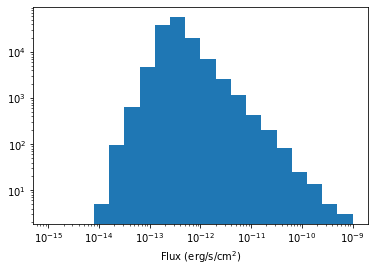

In [5]:
hist = plt.hist(xrs_df['flux'], bins=np.logspace(-15,-9,21), log=True)
plt.xscale('log')
plt.xlabel(r"Flux (erg/s/cm$^2$)")
plt.show()

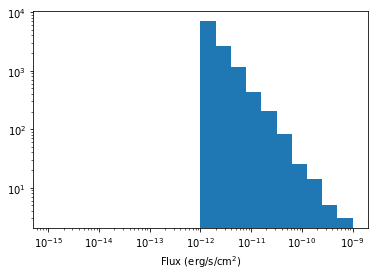

In [6]:
hist = plt.hist(xrs_sorted['flux'], bins=np.logspace(-15,-9,21), log=True)
plt.xscale('log')
plt.xlabel(r"Flux (erg/s/cm$^2$)")
plt.show()

## Create simbad_df

In [7]:
simbad_df = simbad_dataframe_query(xrs_sorted)

eps = 1e-6
def comp(a, b):
    return np.abs(a-b) < eps

new_series = pd.Series(np.repeat('',len(simbad_df)))

ra_series = xrs_sorted['ra']
for idx, row in simbad_df.iterrows():
    i_low = ra_series.searchsorted(row['ra_2'] - eps)
    i_high = ra_series.searchsorted(row['ra_2'] + eps)
    for i in range(i_low,i_high):
        label = ra_series.index[i]
        if comp(xrs_sorted.loc[label,'dec'],row['dec_2']):
            new_series[idx] = xrs_sorted.loc[label,'name']
            
            break


simbad_df['counterpart'] = new_series

## Object classification

In [205]:
# Classification of SIMBAD objects found near 2RXS sources
types, freq = np.unique(simbad_df['main_type'], return_counts=True)
types_df = pd.concat([pd.Series(types, name='type'), pd.Series(freq, name='frequency')], axis=1)
types_df.sort_values('frequency', ascending=False)[:50]

type  frequency
146           Star      13256
60          Galaxy       7561
61           GinCl       3613
160              X       3365
104            PM*       2553
73             HII       2229
64            GlCl       2079
144      Seyfert_1       1842
127          Radio       1032
65           GlCl?       1004
48             ClG        980
46             Cl*        745
0               **        711
89         LensedG        709
122            QSO        700
7            BLLac        669
6             BClG        648
90     LensedImage        608
162            YSO        569
135          RotV*        547
52             EB*        508
98             NIR        455
137            SB*        371
155        Unknown        351
47            Cl*?        339
3    AGN_Candidate        330
9            BYDra        312
81              IR        293
125          RRLyr        293
105             PN        287
126          RSCVn        277
41   Candidate_YSO        251
2              AGN        241
169      low-mass*        225
44       CataclyV*        217
55             EmG        214
87            LPV*        196
156             V*        190
150          TTau*        189
131         RadioG        167
109        PartofG        164
158            WD*        160
100           Nova        159
141            SNR        158
57       Eruptive*        152
11          Blazar        141
106            PN?        120
161             XB        117
76            HMXB        109
121         Pulsar        108

In [5]:
# Types that could indicate valid neutrino source
types_positive = ['AGN', 'AGN_Candidate', 'BClG', 'BLLac', 'BLLac_Candidate', 'Blazar',
                  'Blazar_Candidate', 'GinCl', 'LINER', 'QSO', 'QSO_Candidate', 'Seyfert',
                  'Seyfert_1', 'Seyfert_2', 'GlCl', 'GlCl?']
# Types that could indicate not a valid neutrino source
types_negative = ['Star', 'Galaxy', 'HII', 'YSO', 'BYDra', 'RRLyr', 'PN', 'Candidate_YSO',
                  'Nova', 'PN?']

# All type strings containing `*` are stars
for x in np.unique(simbad_df['main_type']):
    if '*' in x:
        types_negative.append(x)

In [3]:
# 2RXS-SIMBAD mapping at this point is held in the simbad_df column `counterpart` in the form
# of 2RXS object names. In order to perform lookups in the 2RXS -> SIMBAD direction, we will
# build a dictionary that maps 2RXS object names onto simbad_df indices
counterpart_dict = {}
for idx, row in simbad_df.iterrows():
    c = row['counterpart']
    if c not in counterpart_dict:
        counterpart_dict[c] = [idx]
    else:
        counterpart_dict[c].append(idx)

In [4]:
simbad_df

angDist                   main_id          ra        dec  \
0      35.130696  [MAC2016] A2744cl   2416    3.598884 -30.380053   
1      35.133760  [MAC2016] A2744cl   1588    3.591187 -30.393223   
2      35.134847  [MAC2016] A2744cl   2024    3.599388 -30.386154   
3      35.135560  [MAC2016] A2744cl   1574    3.587373 -30.393478   
4      35.196417  [MAC2016] A2744cl   1824    3.579116 -30.389343   
...          ...                       ...         ...        ...   
55321  12.549062                 * del Scl  357.231444 -28.130271   
55322   2.528434     1RXS J234854.6-423053  357.227508 -42.514861   
55323   2.273353     1RXS J234858.3-383155  357.242921 -38.531939   
55324  49.596744              LEDA  607936  357.259500 -38.535000   
55325   5.753230   2MASS J23490753-3311448  357.281349 -33.195756   

       coo_err_maj  coo_err_min  coo_err_angle  nbref         ra_sexa  \
0              NaN          NaN          172.0      2    00 14 23.732   
1              NaN          NaN          172.0      2    00 14 21.885   
2              NaN          NaN          172.0      2    00 14 23.853   
3              NaN          NaN          172.0      2    00 14 20.970   
4              NaN          NaN          172.0      3    00 14 18.988   
...            ...          ...            ...    ...             ...   
55321        0.002        0.002           90.0    137  23 48 55.54658   
55322          NaN          NaN          172.0      0    23 48 54.602   
55323          NaN          NaN          172.0      0    23 48 58.301   
55324        2.500        2.500           90.0      2     23 49 02.28   
55325        0.000        0.000           90.0     13  23 49 07.52386   

             dec_sexa  ...          H          K   u   g   r   i   z  \
0        -30 22 48.19  ...  28.496000  27.275000 NaN NaN NaN NaN NaN   
1        -30 23 35.60  ...  28.044001  27.226000 NaN NaN NaN NaN NaN   
2        -30 23 10.15  ...  26.033001  25.694000 NaN NaN NaN NaN NaN   
3        -30 23 36.52  ...  24.169001  24.347000 NaN NaN NaN NaN NaN   
4        -30 23 21.63  ...  24.238001  23.662001 NaN NaN NaN NaN NaN   
...               ...  ...        ...        ...  ..  ..  ..  ..  ..   
55321  -28 07 48.9745  ...   4.643000   4.532000 NaN NaN NaN NaN NaN   
55322    -42 30 53.50  ...        NaN        NaN NaN NaN NaN NaN NaN   
55323    -38 31 54.98  ...        NaN        NaN NaN NaN NaN NaN NaN   
55324     -38 32 06.0  ...        NaN        NaN NaN NaN NaN NaN NaN   
55325  -33 11 44.7204  ...  14.082000  13.616000 NaN NaN NaN NaN NaN   

            ra_2     dec_2            counterpart  
0        3.58842 -30.38376  2RXS J001421.2-302301  
1        3.58842 -30.38376  2RXS J001421.2-302301  
2        3.58842 -30.38376  2RXS J001421.2-302301  
3        3.58842 -30.38376  2RXS J001421.2-302301  
4        3.58842 -30.38376  2RXS J001421.2-302301  
...          ...       ...                    ...  
55321  357.22752 -28.13069  2RXS J234854.6-280750  
55322  357.22783 -42.51420  2RXS J234854.6-423051  
55323  357.24250 -38.53140  2RXS J234858.2-383153  
55324  357.24250 -38.53140  2RXS J234858.2-383153  
55325  357.28174 -33.19732  2RXS J234907.6-331150  

[55326 rows x 44 columns]

### Attempting to model a probability function of the sky distance between an X-ray source and its 2RXS location

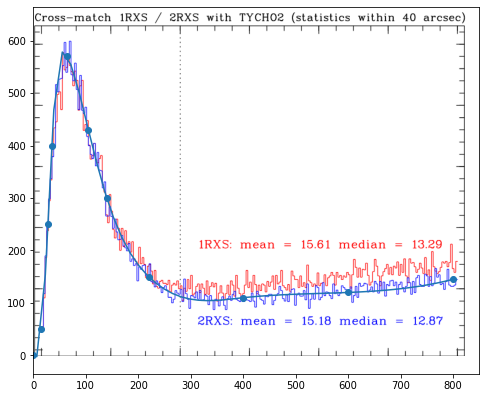

In [6]:
# Visually model the distribution function of position separation between 2RXS objects and
# counterparts in other catalogs using plot of 2RXS-TYCHO2 data, Fig. 21, Boller et al. 2016
# pdf() is the un-normalized probability distribution function with input in arcsec
import matplotlib.image
img = matplotlib.image.imread("2rxs_spread.png")
img = np.flip(img, axis=0)
fig = plt.figure(figsize=(8,8))
plt.imshow(img[85:,135:], origin='lower')

# Visually estimated points
x = np.array([0, 15, 28, 35, 65, 105, 140, 220, 400, 600, 800])
y = np.array([0, 50, 250, 400, 570, 430, 300, 150, 110, 120, 145])

from scipy.interpolate import interp1d

x = x*120/800
pdf = interp1d(x,y,kind='cubic', bounds_error=False, fill_value=0.)
x = x*800/120
ls = np.linspace(1,120)
plt.plot(ls*800/120,pdf(ls))
plt.scatter(x,y)



### Classification of X-ray sources based on simbad sources and pdf (in progress)

In [7]:
# Needs a more sophisticated method for valid results, but this first draft does the job
pos_threshold = 0.7
neg_threshold = 0.5

for idx, xrs in xrs_sorted.iterrows():
    
    # XRS with no counterparts in SIMBAD catalog
    if not xrs['name'] in counterpart_dict:
        xrs_sorted.loc[idx, 'counterpart'] = 'Undecided'
        continue
        
    cpts = simbad_df.loc[counterpart_dict[xrs['name']]]
    
    if cpts['angDist'].min() < 40.:
        s = np.sum([pdf(x) for x in cpts['angDist']])
        s_p = np.sum([pdf(x)*int(t in types_positive) for x,t in zip(cpts['angDist'],cpts['main_type'])])
        s_n = np.sum([pdf(x)*int(t in types_negative) for x,t in zip(cpts['angDist'],cpts['main_type'])])
        
        if s_p/s > pos_threshold:
            xrs_sorted.loc[idx,'counterpart'] = 'Include'
        elif s_n/s > neg_threshold:
            xrs_sorted.loc[idx, 'counterpart'] = 'Exclude'
        else:
            xrs_sorted.loc[idx, 'counterpart'] = 'Undecided'
    else:
        xrs_sorted.loc[idx, 'counterpart'] = 'Undecided'


In [211]:
xrs_sorted[xrs_sorted['counterpart'] == 'Include']

Unnamed: 0  w3___row                   name         ra       dec  \
105094      105094    126572  2RXS J000009.8-633542    0.04111 -63.59525   
2545          2545     98775  2RXS J000019.3-261032    0.08064 -26.17573   
2329          2329    104282  2RXS J000129.7-320838    0.37390 -32.14396   
130720      130720     49243  2RXS J000132.6+211338    0.38616  21.22743   
98746        98746    129685  2RXS J000217.2-672712    0.57171 -67.45344   
...            ...       ...                    ...        ...       ...   
125736      125736     65804  2RXS J235754.3+132418  359.47644  13.40509   
2651          2651     88056  2RXS J235808.5-102837  359.53574 -10.47721   
112185      112185    129586  2RXS J235858.2-603628  359.74252 -60.60779   
1829          1829     98653  2RXS J235919.5-204758  359.83141 -20.79962   
126029      126029     65896  2RXS J235959.1+083354  359.99642   8.56508   

        count_rate  count_rate_error  exposure  source_extent  \
105094      0.2122            0.0305    269.41          0.296   
2545        0.1318            0.0233    314.36          0.131   
2329        0.1599            0.0253    318.26          0.000   
130720      0.0933            0.0197    295.04          0.000   
98746       0.1030            0.0210    314.29          0.000   
...            ...               ...       ...            ...   
125736      0.2330            0.0248    423.65          0.295   
2651        0.1561            0.0244    311.69          0.286   
112185      0.0982            0.0334    152.99          1.081   
1829        0.1060            0.0207    327.26          0.000   
126029      0.1077            0.0181    415.38          0.150   

        source_extent_prob  source_quality_flag  hardness_ratio_1  \
105094                1.17                    0            -0.465   
2545                  0.02                    0            -0.295   
2329                  0.00                    0            -0.531   
130720                0.00                    0             0.597   
98746                 0.00                    0            -0.214   
...                    ...                  ...               ...   
125736                2.95                    0             0.142   
2651                  1.34                    0             0.102   
112185                1.78                    0             0.246   
1829                  0.00                    0            -0.304   
126029                0.09                    0             0.845   

        hardness_ratio_2  Search_Offset  unique_id          flux      Label  \
105094            -0.826       5500.854         24  2.291760e-12  Undecided   
2545               0.130        568.753          9  1.423440e-12  Undecided   
2329              -0.139        918.196          9  1.726920e-12  Undecided   
130720             0.057       2484.081         32  1.007640e-12  Undecided   
98746              0.048       5329.230         24  1.112400e-12  Undecided   
...                  ...            ...        ...           ...        ...   
125736             0.058       2431.273         32  2.516400e-12        NaN   
2651               0.288        424.531          9  1.685880e-12        NaN   
112185             0.357       5633.106         24  1.060560e-12        NaN   
1829              -0.273        274.608          9  1.144800e-12        NaN   
126029             0.155       2497.691         32  1.163160e-12        NaN   

       counterpart  
105094     Include  
2545       Include  
2329       Include  
130720     Include  
98746      Include  
...            ...  
125736     Include  
2651       Include  
112185     Include  
1829       Include  
126029     Include  

[2569 rows x 18 columns]

<BarContainer object of 3 artists>

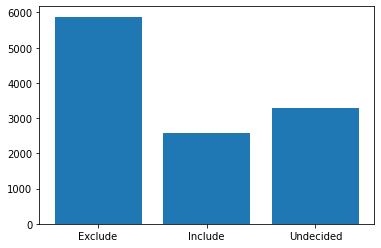

In [8]:
# Distribution of XRS in categories
plt.bar(range(1,4),
       [np.sum(xrs_sorted['counterpart'] == 'Exclude'),
        np.sum(xrs_sorted['counterpart'] == 'Include'),
       np.sum(xrs_sorted['counterpart'] == 'Undecided'),
       ],
       tick_label=['Exclude', 'Include', 'Undecided'])

## Examples of sources automatically classified

The following three code cells grab annotated sky images of 2RXS objects and counterparts in each of the three categories of Include, Exclude, Undecided. The embedded images do not get saved with the notebook so the cells must be run each time.

## Include
Almost all active galaxies or candidate active galaxies, due to our classification method above.

In [21]:
widget_list = []
for idx, xrs in xrs_sorted[xrs_sorted['counterpart'] == 'Include'].sample(10).iterrows():
    df = pd.DataFrame()
    if xrs['name'] in counterpart_dict:
        df = simbad_df.loc[counterpart_dict[xrs['name']]]
    widget_list.append(build_widget(df, xrs['ra'], xrs['dec']))
widgets.GridBox(widget_list, layout=widgets.Layout(grid_template_columns="repeat(2, 300px)"))

Querying hips2fits...
Returned <Response [200]>
Querying hips2fits...
Returned <Response [200]>
Querying hips2fits...
Returned <Response [200]>
Querying hips2fits...
Returned <Response [200]>
Querying hips2fits...
Returned <Response [200]>
Querying hips2fits...
Returned <Response [200]>
Querying hips2fits...
Returned <Response [200]>
Querying hips2fits...
Returned <Response [200]>
Querying hips2fits...
Returned <Response [200]>
Querying hips2fits...
Returned <Response [200]>


GridBox(children=(VBox(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x0…

## Exclude
Mostly bright stars near the 2RXS source.

In [11]:
widget_list = []
for idx, xrs in xrs_sorted[xrs_sorted['counterpart'] == 'Exclude'].sample(10).iterrows():
    df = pd.DataFrame()
    if xrs['name'] in counterpart_dict:
        df = simbad_df.loc[counterpart_dict[xrs['name']]]
    widget_list.append(build_widget(df, xrs['ra'], xrs['dec']))
widgets.GridBox(widget_list, layout=widgets.Layout(grid_template_columns="repeat(2, 300px)"))

Querying hips2fits...
Returned <Response [200]>
Querying hips2fits...
Returned <Response [200]>
Querying hips2fits...
Returned <Response [200]>
Querying hips2fits...
Returned <Response [200]>
Querying hips2fits...
Returned <Response [200]>
Querying hips2fits...
Returned <Response [200]>
Querying hips2fits...
Returned <Response [200]>
Querying hips2fits...
Returned <Response [200]>
Querying hips2fits...
Returned <Response [200]>
Querying hips2fits...
Returned <Response [200]>


GridBox(children=(VBox(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x0…

## Undecided
Mostly X-ray sources in SIMBAD (e.g. from 1RXS) with no positive/negative type objects identified nearby. Some ambiguous objects due positive as well as negative type objects appearing close to the 2RXS location.

In [20]:
widget_list = []
for idx, xrs in xrs_sorted[xrs_sorted['counterpart'] == 'Undecided'].sample(10).iterrows():
    df = pd.DataFrame()
    if xrs['name'] in counterpart_dict:
        df = simbad_df.loc[counterpart_dict[xrs['name']]]
    widget_list.append(build_widget(df, xrs['ra'], xrs['dec']))
widgets.GridBox(widget_list, layout=widgets.Layout(grid_template_columns="repeat(2, 300px)"))

Querying hips2fits...
Returned <Response [200]>
Querying hips2fits...
Returned <Response [200]>
Querying hips2fits...
Returned <Response [200]>
Querying hips2fits...
Returned <Response [200]>
Querying hips2fits...
Returned <Response [200]>
Querying hips2fits...
Returned <Response [200]>
Querying hips2fits...
Returned <Response [200]>
Querying hips2fits...
Returned <Response [200]>
Querying hips2fits...
Returned <Response [200]>
Querying hips2fits...
Returned <Response [200]>


GridBox(children=(VBox(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x0…

## Save xrs_df

In [ ]:
xrs_df.to_pickle('xrs.pickle')

## Save xrs_sorted

In [ ]:
xrs_sorted.to_pickle('xrs_sorted.pickle')

## Save simbad_df

In [ ]:
simbad_df.to_pickle('simbad.pickle')

## Reference Search
Using SIMBAD http requests again, we can quickly find references which may identify X-ray sources. However, 2RXS is not in SIMBAD so we are limited to references which also appear in other X-ray catalogs such as 1RXS. We can use this to disambiguate the sources marked `Undecided`.

In [22]:
xrs_undecided = xrs_sorted[xrs_sorted['counterpart'] == 'Undecided']

In [23]:
simbad_undecided = pd.DataFrame(columns=simbad_df.columns)

for idx,simbad_obj in simbad_df[simbad_df['main_type'] == 'X'].iterrows():
    mask = xrs_undecided.name == simbad_obj.counterpart
    if not xrs_undecided[mask].empty:
        simbad_undecided = pd.concat([simbad_undecided, pd.DataFrame([simbad_obj],columns=simbad_df.columns)])

In [ ]:
##### Many http queries done here, may take several minutes ######
#refs_df = pd.DataFrame(columns=header)
refs_df = pd.DataFrame()

# Query for references (one query per SIMBAD object)
for idx,simbad_obj in simbad_undecided.iterrows():
    df = simbad_refs_query(simbad_obj.main_id)
    df['main_id'] = simbad_obj.main_id
    refs_df = pd.concat([refs_df, df])

## Most common papers (papers that include the most sources in its catalog)

In [ ]:
freq = pd.DataFrame(np.unique(refs_df['Bibcode/DOI'], return_counts=True)).T
freq.columns = ['Bibcode/DOI', 'Count']
freq = freq.sort_values('Count', ascending=False)
freq

## Save refs_df

In [6]:
refs_df.to_pickle('refs.pickle')

## Image browsing for categorization (work in progress)

In [ ]:
widget_list = []
options = ["Undecided", "Include", "Exclude"]
page_size = 20
page_i = 0
idx_list = []

for idx, xrs in xrs_sorted[page_i:page_i+page_size].iterrows():
    idx_list.append(idx)
    
    # TODO: replace with MOC
    hips = None
    if xrs['dec'] > -30:
        hips = 'CDS/P/PanSTARRS/DR1/color-z-zg-g'
    
    print("Querying hips2fits...")
    h2f_response = hips2fits_query(xrs['ra'], xrs['dec'],
                                   fov=.02,
                                   width=600,
                                   height=600,
                                   hips=hips)
    print("Returned {:s}".format(str(h2f_response)))
    tf = TemporaryFile()
    
    hdr = Header.fromstring(h2f_response.content[6:2000])
    w = wcs.WCS(hdr)
    # reverse y coord because Pillow defines origin as top left image corner
    w.wcs.cdelt[1] = -w.wcs.cdelt[1]
    
    image = Image.open(BytesIO(h2f_response.content))
    draw = ImageDraw.Draw(image)
    
    simbad_df = simbad(xrs['ra'], xrs['dec'])
    image_annotate(draw,simbad_df,w)
    
    image.save(tf, 'JPEG', quality=90)
    tf.seek(0)
    image = tf.read()
    
    widget = widgets.VBox(children=[widgets.Image(value=image, layout=widgets.Layout(justify_content='space-around')),
                                    widgets.ToggleButtons(options=options, button_width='120px'),]
                         )
    widget_list.append(widget)
    
widgets.GridBox(widget_list, layout=widgets.Layout(grid_template_columns="repeat(2, 300px)"))

In [ ]:
for idx, widget in zip(idx_list, widget_list):
    xrs_sorted.loc[idx,'Label'] = widget.children[1].value